# Cancer Detection Project

## Problem Description

The goal of this project is to build a binary image classifier that detects the presence of metastatic cancer in small (32x32) image patches extracted from larger pathology slides. The dataset is a cleaned version of the PatchCamelyon (PCam) benchmark. The dataset is balanced and suitable for training convolutional neural networks on standard hardware.

Data Overview:

Image size: 32x32 pixels (RGB)

Labels: Binary (0 = no tumor, 1 = tumor)

Train/test split: Provided by Kaggle

Format: PNG images with a corresponding CSV file for IDs and labels

## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tifffile as tiff
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

Transforming images to 32x32

In [2]:
transform = transforms.Compose([
    transforms.CenterCrop(32),  # crop center 32x32 patch
    transforms.ToTensor(),      # convert to tensor and normalize
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize RGB channels
])

## Load Data

In [3]:
df = pd.read_csv("train_labels.csv")

print("Total Samples:", df.shape[0])
print(df['label'].value_counts())
df.head()

Total Samples: 220025
label
0    130908
1     89117
Name: count, dtype: int64


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## EDA

### Label Distribution

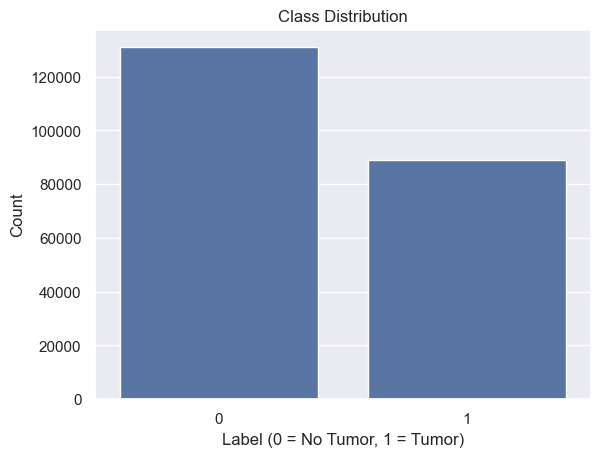

In [4]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.xlabel("Label (0 = No Tumor, 1 = Tumor)")
plt.ylabel("Count")
plt.show()

We can see that there is a slight class imbalance with 130,908 images labeled as without a tumor and 89,117 images labeled with a tumor, however this imbalance isn't large enough to cause issues with building the model.

### Visualize Random Image Samples by Class

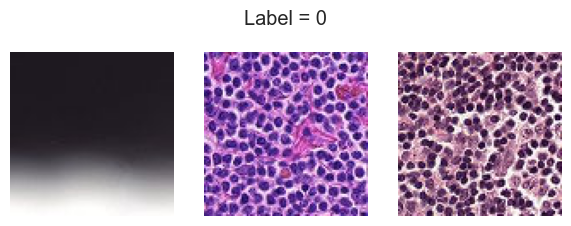

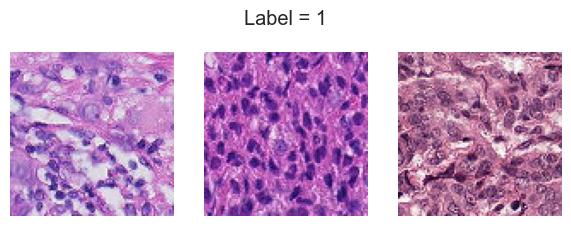

In [5]:
# function to visualize 3 random images for each class
def show_random_images(df, label, img_dir, num_images=3):
    subset = df[df['label'] == label].sample(num_images)
    plt.figure(figsize=(6,6))
    for idx, row in enumerate(subset.itertuples()):
        img_path = os.path.join(img_dir, f"{row.id}.tif")
        img = Image.open(img_path)
        plt.subplot(3, 3, idx + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Label = {label}")
    plt.tight_layout()
    plt.show()

# View sample images
show_random_images(df, label=0, img_dir="train")
show_random_images(df, label=1, img_dir="train")

As we can see, the variation in color and size of the cells, varies widely across classes as well as within classes.

### Custom Dataset and Transformations

We will create our own dataset that finds each image and coordinates that with it's class label, group the images into batches and shuffle them into batches using the following functions.

In [6]:
class PCamDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.tif")
        image = tiff.imread(img_path)
        image = Image.fromarray(image)  # Convert to PIL for transforms
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.float32)
        return image, label

### Data Split

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = PCamDataset(train_df, img_dir="train", transform=transform)
val_dataset = PCamDataset(val_df, img_dir="train", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")

Train size: 176020
Validation size: 44005


## CNN Model Building

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 16, 16]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 8, 8]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                # [B, 64*8*8]
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),                           # Output = 1 (binary)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

### Model Training Function

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    return running_loss / len(dataloader.dataset)

### Model Evaluation Function

In [10]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader.dataset), auc

### Model Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid + binary cross-entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
val_aucs = []

EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

Epoch 1/5 | Train Loss: 0.4570 | Val Loss: 0.4464 | Val AUC: 0.8803
Epoch 2/5 | Train Loss: 0.4135 | Val Loss: 0.3992 | Val AUC: 0.8989
Epoch 3/5 | Train Loss: 0.3878 | Val Loss: 0.3793 | Val AUC: 0.9079
Epoch 4/5 | Train Loss: 0.3685 | Val Loss: 0.3589 | Val AUC: 0.9157
Epoch 5/5 | Train Loss: 0.3536 | Val Loss: 0.3546 | Val AUC: 0.9190


Best Epoch: 5 with validation AUC = 0.919

### Early Stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=3, mode='max'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode  # 'max' for metrics like AUC, 'min' for losses

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif (self.mode == 'max' and score <= self.best_score) or (self.mode == 'min' and score >= self.best_score):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), 'best_model.pt')

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

early_stopper = EarlyStopping(patience=3, mode='max')

EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    early_stopper(val_auc, model)
    if early_stopper.early_stop:
        print("Early stopping triggered!")
        break

# Load the best model after training
model.load_state_dict(torch.load('best_model.pt'))

Epoch 1/5 | Train Loss: 0.4485 | Val Loss: 0.4092 | Val AUC: 0.8938
Epoch 2/5 | Train Loss: 0.3985 | Val Loss: 0.3765 | Val AUC: 0.9070
Epoch 3/5 | Train Loss: 0.3736 | Val Loss: 0.3561 | Val AUC: 0.9161
Epoch 4/5 | Train Loss: 0.3579 | Val Loss: 0.3570 | Val AUC: 0.9157
Epoch 5/5 | Train Loss: 0.3446 | Val Loss: 0.3492 | Val AUC: 0.9202


<All keys matched successfully>

Best Epoch: 5 with validation AUC = 0.9202

### Batch Normalization

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

early_stopper = EarlyStopping(patience=3, mode='max')

EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    early_stopper(val_auc, model)
    if early_stopper.early_stop:
        print("Early stopping triggered!")
        break

# Load the best model after training
model.load_state_dict(torch.load('best_model.pt'))

Epoch 1/5 | Train Loss: 0.4548 | Val Loss: 0.4116 | Val AUC: 0.8876
Epoch 2/5 | Train Loss: 0.4247 | Val Loss: 0.3964 | Val AUC: 0.8975
Epoch 3/5 | Train Loss: 0.4069 | Val Loss: 0.3910 | Val AUC: 0.9082
Epoch 4/5 | Train Loss: 0.3925 | Val Loss: 0.3824 | Val AUC: 0.9111
Epoch 5/5 | Train Loss: 0.3824 | Val Loss: 0.3538 | Val AUC: 0.9189


<All keys matched successfully>

Best Epoch: 5 with validation AUC = 0.9189

## Submission

In [36]:
class PCamTestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_id = row['id']
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = tiff.imread(img_path)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [37]:
test_df = pd.read_csv("sample_submission.csv")
test_dataset = PCamTestDataset(test_df, img_dir="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [38]:
all_ids = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze(1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_ids.extend(ids)
        all_preds.extend(probs)

submission_df = pd.DataFrame({
    'id': all_ids,
    'label': [int(p > 0.5) for p in all_preds]
})

submission_df.to_csv("submission.csv", index=False)

In [39]:
submission_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


## Results

All models performed well to distinguish between cancerous cells with AUCs all above 0.9. The best model was CNN with early stopping, but without the batch normalization that produced an AUC of 0.9202.

## Future Work

Returning back to this project, it would be worthwhile to explore CNNs with more advanced architecture such as rotation equivariant CNNs. Additionally, we could use Grad-CAM to visualize which regions of the image the model uses to make cancer predictions which can be helpful for practical interpretability. We can also try to augment the images to see how well the model performs with rotation, flips, and changes to brightness and color.